In [1]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow h5py tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\guanc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
# os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/bin")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

### GPU Acceleration
Enable GPU Acceleration if you have a NVIDIA GPU with compute capability >= 7.0

In [3]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

# ## ENABLE THIS IF YOU HAVE RTX GPU WITH COMPUTE CAPABILITY 7.0 or higher
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

### Loading Data

In [4]:
# pd.set_option('display.max_rows', None)
fp = "./features_combined.csv"
batch_pd = pd.read_csv(fp, index_col=False)
dataset = batch_pd.copy()
dataset.sort_values(by=['policy'], ascending=True, inplace=True)
# dataset
dataset.isna().sum()
dataset = dataset.dropna().drop(columns=['policy', 'barcode'])

In [5]:
## Global Model Config
EPOCHS = 2500
UNITS = 1
LEARNING_RATE = 0.01
CALLBACK = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=15, min_delta=0.01)

## Data split
Split by policy fast charge first(5C - 8C), and then by policy slow charge (1C - 4C)


In [6]:
normal_charge_dataset = dataset.iloc[0:29, :]
fast_charge_dataset = dataset.iloc[29:, :]
print(normal_charge_dataset.shape, fast_charge_dataset.shape)

(29, 15) (51, 15)


## Fast-Charge Test-Train split

In [7]:
fast_charge_train_ds = fast_charge_dataset.iloc[0::2, :]
fast_charge_test_ds = fast_charge_dataset.iloc[1::2, :]
# sns.pairplot(fast_charge_train_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
# sns.pairplot(fast_charge_test_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
# fast_charge_test_ds
fast_charge_train_ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle_life,26.0,709.000000,193.796801,462.000000,522.500000,702.000000,871.500000,1053.000000
QD2,26.0,1.075827,0.009765,1.042137,1.071382,1.076585,1.079837,1.094639
QD(Max-2),26.0,0.075046,0.355479,0.003094,0.004385,0.005073,0.006637,1.817914
QD100,26.0,1.078456,0.009938,1.047023,1.074762,1.079679,1.084353,1.095349
QDiffMin,26.0,-1.382534,0.113311,-1.558986,-1.484180,-1.358293,-1.301282,-1.196677
QDiffMean,26.0,-1.727856,0.132935,-1.938902,-1.845678,-1.687956,-1.632366,-1.484179
QDiffVar,26.0,-3.730928,0.231815,-4.099414,-3.917423,-3.678960,-3.560911,-3.367237
QDiffSkew,26.0,-0.938650,0.414006,-1.993884,-1.193384,-0.859011,-0.607692,-0.368971
QDiffKurtosis,26.0,0.103841,0.022956,0.030487,0.091231,0.110055,0.119106,0.134112
QDiffStart,26.0,-4.188883,0.509219,-5.440747,-4.527603,-4.178977,-3.776694,-3.399592


In [8]:
fastcharge_train_features = fast_charge_train_ds.copy()
fastcharge_test_features = fast_charge_test_ds.copy()

train_labels = fastcharge_train_features.pop('cycle_life')
test_labels = fastcharge_test_features.pop('cycle_life')


# Linear Regress
### Layering and Build Model

In [9]:
# Normalize layer
QDiffLinVar = np.array(fastcharge_train_features['QDiffLinVar'])
QDiffLinVar_normalizer = layers.Normalization(input_shape=[1,], axis=None)
QDiffLinVar_normalizer.adapt(QDiffLinVar)

# Input and output layers
variance_model_fast_charge = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(UNITS, input_dim=1 ,activation='relu' ),
    layers.Dense(1, activation='linear', dtype='float32', name='predictions')
])
variance_model_fast_charge.summary()

print("Number of weights after calling the model:", len(variance_model_fast_charge.weights))
print("weights:", len(variance_model_fast_charge.weights))
print("trainable_weights:", len(variance_model_fast_charge.trainable_weights))
print("non_trainable_weights:", len(variance_model_fast_charge.non_trainable_weights))

## Compile the model and make a prediction
variance_model_fast_charge.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
    )

## Making a prediction on first 10 samples
variance_model_fast_charge.predict(QDiffLinVar[:10])

2022-07-22 15:36:32.542897: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 predictions (Dense)         (None, 1)                 2         
                                                                 
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________
Number of weights after calling the model: 7
weights: 7
trainable_weights: 4
non_trainable_weights: 3


array([[0.42582065],
       [0.8385598 ],
       [0.08917356],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.26612493],
       [1.2571664 ],
       [0.5611741 ],
       [0.650409  ]], dtype=float32)

### Train the Model

In [10]:
%%time
tf.debugging.set_log_device_placement(True)
history = variance_model_fast_charge.fit(
    fastcharge_train_features['QDiffLinVar'],
    train_labels,
    epochs=EPOCHS,
    verbose=2,
    # callbacks=[CALLBACK],
    validation_data=(fastcharge_test_features['QDiffLinVar'], test_labels)
    )

Epoch 1/2500
1/1 - 0s - loss: 538426.3125 - mae: 708.6655 - val_loss: 447392.8438 - val_mae: 647.1072 - 485ms/epoch - 485ms/step
Epoch 2/2500
1/1 - 0s - loss: 538398.7500 - mae: 708.6434 - val_loss: 447364.1250 - val_mae: 647.0822 - 24ms/epoch - 24ms/step
Epoch 3/2500
1/1 - 0s - loss: 538370.9375 - mae: 708.6212 - val_loss: 447335.1250 - val_mae: 647.0571 - 21ms/epoch - 21ms/step
Epoch 4/2500
1/1 - 0s - loss: 538342.8750 - mae: 708.5988 - val_loss: 447305.8750 - val_mae: 647.0317 - 19ms/epoch - 19ms/step
Epoch 5/2500
1/1 - 0s - loss: 538314.6875 - mae: 708.5760 - val_loss: 447276.3750 - val_mae: 647.0060 - 21ms/epoch - 21ms/step
Epoch 6/2500
1/1 - 0s - loss: 538286.1250 - mae: 708.5532 - val_loss: 447246.5625 - val_mae: 646.9800 - 20ms/epoch - 20ms/step
Epoch 7/2500
1/1 - 0s - loss: 538257.3750 - mae: 708.5300 - val_loss: 447216.5312 - val_mae: 646.9539 - 19ms/epoch - 19ms/step
Epoch 8/2500
1/1 - 0s - loss: 538228.3750 - mae: 708.5068 - val_loss: 447185.8750 - val_mae: 646.9272 - 19ms/

,loss,mae,val_loss,val_mae,epoch
0,733.775383,26.620771,668.874311,25.438301,0
1,733.756601,26.620357,668.852843,25.437811,1
2,733.737649,26.619939,668.831163,25.437316,2
3,733.718526,26.619518,668.809296,25.436817,3
4,733.699317,26.619092,668.787242,25.436312,4
...,...,...,...,...,...
2495,109.469843,9.776117,101.572312,9.327673,2495
2496,109.461105,9.775769,101.582354,9.328146,2496
2497,109.452419,9.775422,101.592380,9.328619,2497
2498,109.443818,9.775077,101.602401,9.329089,2498


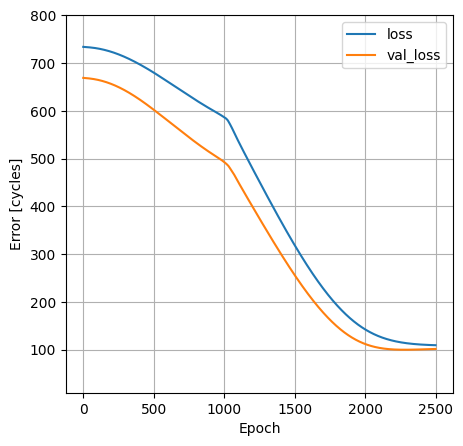

In [11]:
def plot_loss(history):
  plt.figure("BaseMode", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.plot(np.sqrt(history.history['loss']), label='loss')
  plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
  # plt.ylim([200, 130])
  plt.ylim([10, 800])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)
  
plot_loss(history)

## Display model's loss and accuracy history
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist

### Evaluate the Model and Save the Results for comparison

In [12]:
test_results = {}
test_results['fast_charge_variance_model'] = variance_model_fast_charge.evaluate(
    fastcharge_test_features['QDiffLinVar'],
    test_labels, verbose=1) #sqrt for mse
## Based on Author's calculation for MSE
test_results['fast_charge_variance_model'][0] = test_results['fast_charge_variance_model'][0] ** 0.5
pd.DataFrame(test_results, index=['MSE', 'MAE']).T

1/1 [==============================] - 0s 34ms/step - loss: 10325.0830 - mae: 87.0406


,MSE,MAE
fast_charge_variance_model,101.612416,87.040634


### Make Predictions

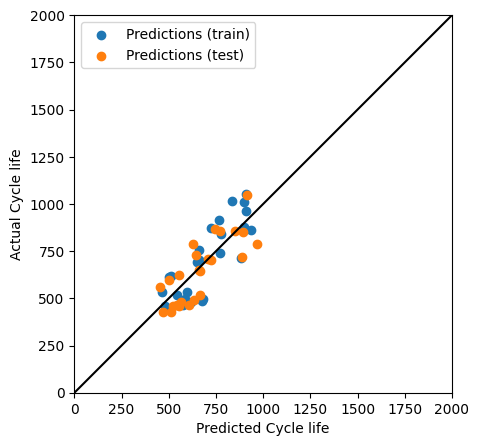

In [13]:
def plot_prediction(y_train, y_test):
  plt.figure("BaseModelPrediction", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.axes(aspect='equal')
  plt.scatter(y_train, train_labels, label='Predictions (train)')
  plt.scatter(y_test, test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

train_prediction = variance_model_fast_charge.predict(fast_charge_train_ds['QDiffLinVar'])
test_prediction = variance_model_fast_charge.predict(fast_charge_test_ds['QDiffLinVar'])
train_prediction
plot_prediction(train_prediction, test_prediction)

# Transfer Learning

### Normal-charge Data Train-Test split

In [14]:
normal_charge_train_ds = normal_charge_dataset.iloc[0::2, :]
normal_charge_test_ds = normal_charge_dataset.iloc[1::2, :]
# sns.pairplot(normal_charge_train_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
# sns.pairplot(normal_charge_test_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')

normalcharge_train_features = normal_charge_train_ds.copy()
normalcharge_test_features = normal_charge_test_ds.copy()

normal_train_labels = normalcharge_train_features.pop('cycle_life')
normal_test_labels = normalcharge_test_features.pop('cycle_life')

### Model Building
Transfer Learning Model

In [15]:
## Make a copy of base model
variance_model_normal_charge_tl = variance_model_fast_charge
## Freezing every layer except the last layer
for layer in variance_model_normal_charge_tl.layers[:-1]:
  layer.trainable = False
variance_model_normal_charge_tl.summary()

variance_model_normal_charge_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 predictions (Dense)         (None, 1)                 2         
                                                                 
Total params: 7
Trainable params: 2
Non-trainable params: 5
_________________________________________________________________


Traditional Model

In [16]:
variance_model_normal_charge_traditional = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(UNITS, input_dim=1, activation='relu'),
    layers.Dense(1, activation='linear', dtype='float32', name='predictions')
])
variance_model_normal_charge_traditional.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
    )


### Training the Models

In [17]:
%%time
history_tl = variance_model_normal_charge_tl.fit(
    normalcharge_train_features['QDiffLinVar'],
    normal_train_labels,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(normalcharge_test_features['QDiffLinVar'], normal_test_labels),
    callbacks=[CALLBACK]
    )

Epoch 1/2500
1/1 - 1s - loss: 22946.9277 - mae: 128.7780 - val_loss: 16218.3037 - val_mae: 97.0063 - 578ms/epoch - 578ms/step
Epoch 2/2500
1/1 - 0s - loss: 22886.1270 - mae: 128.5824 - val_loss: 16180.8613 - val_mae: 96.9002 - 32ms/epoch - 32ms/step
Epoch 3/2500
1/1 - 0s - loss: 22825.5293 - mae: 128.3869 - val_loss: 16143.5654 - val_mae: 96.7941 - 93ms/epoch - 93ms/step
Epoch 4/2500
1/1 - 0s - loss: 22765.1504 - mae: 128.1914 - val_loss: 16106.4199 - val_mae: 96.6881 - 43ms/epoch - 43ms/step
Epoch 5/2500
1/1 - 0s - loss: 22704.9785 - mae: 127.9959 - val_loss: 16069.4229 - val_mae: 96.5820 - 45ms/epoch - 45ms/step
Epoch 6/2500
1/1 - 0s - loss: 22645.0332 - mae: 127.8005 - val_loss: 16032.5771 - val_mae: 96.4761 - 39ms/epoch - 39ms/step
Epoch 7/2500
1/1 - 0s - loss: 22585.3203 - mae: 127.6052 - val_loss: 15995.8955 - val_mae: 96.3701 - 35ms/epoch - 35ms/step
Epoch 8/2500
1/1 - 0s - loss: 22525.8340 - mae: 127.4100 - val_loss: 15959.3662 - val_mae: 96.2642 - 42ms/epoch - 42ms/step
Epoch 

In [18]:
%%time
history_traditional = variance_model_normal_charge_traditional.fit(
    normalcharge_train_features['QDiffLinVar'],
    normal_train_labels,
    epochs=EPOCHS,
    verbose=2,
    # callbacks=[CALLBACK],
    validation_data=(normalcharge_test_features['QDiffLinVar'], normal_test_labels))

Epoch 1/2500
1/1 - 0s - loss: 557987.5625 - mae: 677.8231 - val_loss: 393802.6875 - val_mae: 561.5874 - 427ms/epoch - 427ms/step
Epoch 2/2500
1/1 - 0s - loss: 557918.5000 - mae: 677.7892 - val_loss: 393758.4375 - val_mae: 561.5632 - 22ms/epoch - 22ms/step
Epoch 3/2500
1/1 - 0s - loss: 557848.8125 - mae: 677.7551 - val_loss: 393713.7500 - val_mae: 561.5389 - 23ms/epoch - 23ms/step
Epoch 4/2500
1/1 - 0s - loss: 557778.5625 - mae: 677.7207 - val_loss: 393668.5938 - val_mae: 561.5143 - 23ms/epoch - 23ms/step
Epoch 5/2500
1/1 - 0s - loss: 557707.4375 - mae: 677.6861 - val_loss: 393623.0938 - val_mae: 561.4896 - 22ms/epoch - 22ms/step
Epoch 6/2500
1/1 - 0s - loss: 557635.6875 - mae: 677.6511 - val_loss: 393577.1875 - val_mae: 561.4646 - 22ms/epoch - 22ms/step
Epoch 7/2500
1/1 - 0s - loss: 557563.2500 - mae: 677.6158 - val_loss: 393530.7812 - val_mae: 561.4395 - 23ms/epoch - 23ms/step
Epoch 8/2500
1/1 - 0s - loss: 557490.0625 - mae: 677.5800 - val_loss: 393484.0312 - val_mae: 561.4142 - 23ms/

### Plot loss graph and Evaluate

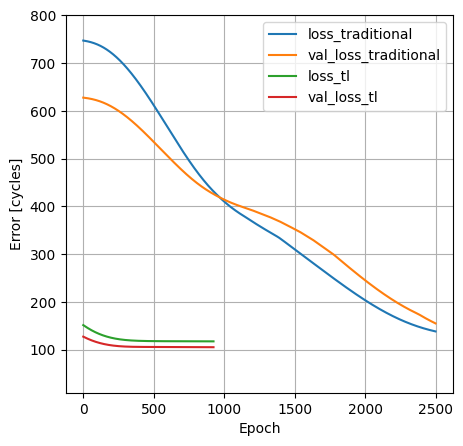

In [19]:
def plot_loss(hist_trad, hist_tl):
  plt.figure("TransferLearning vs Traditional", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.plot(np.sqrt(hist_trad.history['loss']), label='loss_traditional')
  plt.plot(np.sqrt(hist_trad.history['val_loss']), label='val_loss_traditional')
  plt.plot(np.sqrt(hist_tl.history['loss']), label='loss_tl')
  plt.plot(np.sqrt(hist_tl.history['val_loss']), label='val_loss_tl')
  # plt.ylim([200, 130])
  plt.ylim([10, 800])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)

plot_loss(history_traditional, history_tl)

# hist = pd.DataFrame(history_tl.history)
# hist = hist.pow(0.5) # Power 1/2 is the same as square root
# hist['epoch'] = history.epoch
# hist

# hist2 = pd.DataFrame(history_traditional.history)
# hist2 = hist.pow(0.5)
# hist2['epoch'] = history_traditional.epoch
# hist2

In [20]:
test_results['normal_charge_variance_model_tl'] = variance_model_normal_charge_tl.evaluate(
    normalcharge_test_features['QDiffLinVar'],
    normal_test_labels, verbose=1) #sqrt for mse
test_results['normal_charge_variance_model_traditional'] = variance_model_normal_charge_traditional.evaluate(
    normalcharge_test_features['QDiffLinVar'],
    normal_test_labels, verbose=1) #sqrt for mse

1/1 [==============================] - 0s 22ms/step - loss: 24043.2754 - mae: 135.7725


### Make Predictions

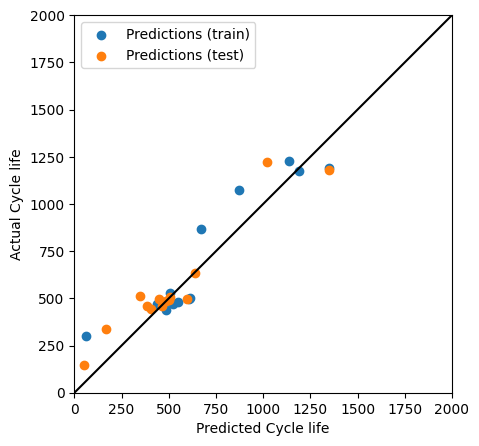

In [21]:
def plot_prediction(y_train, y_test):
  plt.figure("Transfer Learning vs Traditional", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.axes(aspect='equal')
  plt.scatter(y_train, normal_train_labels, label='Predictions (train)')
  plt.scatter(y_test, normal_test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

normal_train_prediction = variance_model_normal_charge_tl.predict(normal_charge_train_ds['QDiffLinVar'])
normal_test_prediction = variance_model_normal_charge_tl.predict(normal_charge_test_ds['QDiffLinVar'])
plot_prediction(normal_train_prediction, normal_test_prediction)

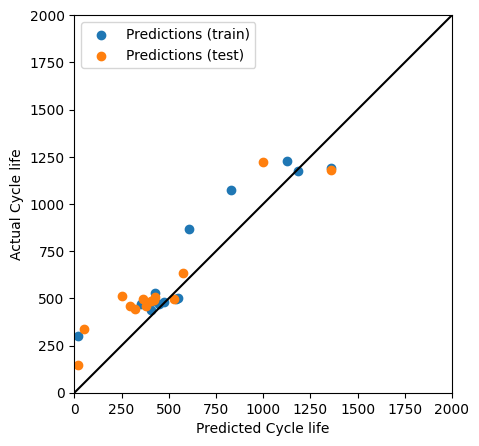

In [22]:
normal_train_prediction2 = variance_model_normal_charge_traditional.predict(normal_charge_train_ds['QDiffLinVar'])
normal_test_prediction2 = variance_model_normal_charge_traditional.predict(normal_charge_test_ds['QDiffLinVar'])
plot_prediction(normal_train_prediction2, normal_test_prediction2)

### Final Results and conclusions

In [23]:
test_results['normal_charge_variance_model_tl'][0] = test_results['normal_charge_variance_model_tl'][0] ** 0.5
test_results['normal_charge_variance_model_traditional'][0] = test_results['normal_charge_variance_model_traditional'][0] ** 0.5
pd.DataFrame(test_results, index=['RMSE', 'MAE']).T

,RMSE,MAE
fast_charge_variance_model,101.612416,87.040634
normal_charge_variance_model_tl,105.246896,77.934517
normal_charge_variance_model_traditional,155.058942,135.772491


# Scratch Test

In [24]:
# model = tf.keras.Sequential(
#     [
#         layers.Dense(2, activation="relu"),
#         layers.Dense(3, activation="relu"),
#         layers.Dense(4),
#     ]
# ) 
# model.summary()